In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data:

In [2]:
train_df = pd.read_csv("./train_data_all.csv")
test_df = pd.read_csv("./test_data_all.csv")

In [3]:
print("Number of instances in the train dataset:", train_df.shape[0])
print("Number of instances in the test dataset:", test_df.shape[0])

Number of instances in the train dataset: 30922
Number of instances in the test dataset: 7297


In [4]:
train_df.sample(5)

,id,title,description,project,label
24597,5b475c8dc298bd5a8f822eb6,DomainStatistics to aggregate by TLD,The DomainStatistics tool aggregates counts by...,nutch,0
22460,5c57f503cf244d7545c839ef,Allow tika config parameter,It would be nice to have an option to pass a t...,manifoldcf,0
5098,5b3e0418faaadd4ca6c3b075,Contribute lifecycle events listeners via DI,"Contribute lifecycle events listeners via DI, ...",cayenne,0
16862,5bdc014716772b0aa531f39b,NameNode endpoint exposed to gateway clients i...,"Started Sandbox HDP Bombardier2, in VirtualBo...",knox,1
28038,5b9bcf43f16c8726d2832c63,Bufferpool integer size overflow w/ entries >2GB,The recent buffer pool integration of frames i...,systemml,1


In [5]:
test_df.sample(5)

,id,title,description,project,label
329,59b64e11e46e1360924a8e19,contrib/javascript is not packaged into releases,the contrib/javascript directory is (apparentl...,lucene-solr,0
1955,59b6577ee46e1360924b4eeb,Add support for terms in BytesRef format to Te...,It would be good to directly allow BytesRefs i...,lucene-solr,0
6157,5df3b0ddbe4a1617bff14d14,PATCH: CGIServlet does not terminate child aft...,CGIServlet does not kill CGI child process on ...,tomcat,0
6536,5df3c89cbe4a1617bff16e05,Parans trustStoreType trustStorePass trustStor...,When admin configure server.xml file its write...,tomcat,1
5926,5df3a1e0be4a1617bff135ed,"""Scripting elements are disallowed here"" excep...",[jdk 1.4.2_04]\n\nI got the exception for a sc...,tomcat,1


### Clean the data:

In [6]:
print("Number of missing titles in the train dataset:", train_df["title"].isnull().sum())
print("Number of missing titles in the test dataset:", test_df["title"].isnull().sum())

print("Number of missing descriptions in the train dataset:", train_df["description"].isnull().sum())
print("Number of missing descriptions in the test dataset:", test_df["description"].isnull().sum())

Number of missing titles in the train dataset: 0
Number of missing titles in the test dataset: 0
Number of missing descriptions in the train dataset: 0
Number of missing descriptions in the test dataset: 9


In [7]:
test_df.loc[test_df["description"].isnull(), "description"] = ""

In [8]:
print("Number of missing labels in the train dataset:", train_df["label"].isnull().sum())
print("Number of missing labels in the test dataset:", test_df["label"].isnull().sum())

Number of missing labels in the train dataset: 0
Number of missing labels in the test dataset: 0


In [9]:
print(f"Number of duplicated titles and descriptions in the train dataset: {train_df[["title", "description"]].duplicated().sum()} ({train_df[["title", "description"]].duplicated().sum()/train_df.shape[0]:.2%})")
print(f"Number of duplicated titles and descriptions in the test dataset: {test_df[["title", "description"]].duplicated().sum()} ({test_df[["title", "description"]].duplicated().sum()/test_df.shape[0]:.2%})")

Number of duplicated titles and descriptions in the train dataset: 64 (0.21%)
Number of duplicated titles and descriptions in the test dataset: 0 (0.00%)


### Analyze distributions:

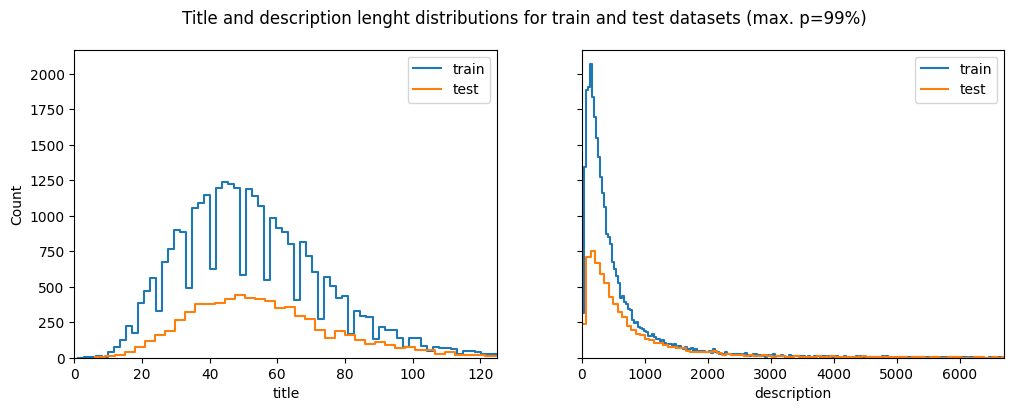

In [10]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
sns.histplot(train_df["title"].str.len(), element="step", fill=False, ax=axes[0])
sns.histplot(test_df["title"].str.len(), element="step", fill=False, ax=axes[0])
axes[0].set_xlim([
    0,
    pd.concat([
        train_df["title"].str.len(),
        test_df["title"].str.len()
    ], axis=1, ignore_index=True).quantile(.99).max()
])
axes[0].legend(labels=["train", "test"])
sns.histplot(train_df["description"].str.len(), element="step", fill=False, ax=axes[1])
sns.histplot(test_df["description"].str.len(), element="step", fill=False, ax=axes[1])
axes[1].set_xlim([
    0,
    pd.concat([
        train_df["description"].str.len(),
        test_df["description"].str.len()
    ], axis=1, ignore_index=True).quantile(.99).max()
])
axes[1].legend(labels=["train", "test"])
plt.suptitle("Title and description lenght distributions for train and test datasets (max. p=99%)")
plt.show()

In [11]:
label_stats = pd.concat([
    train_df["label"].value_counts(dropna=False, normalize=True),
    test_df["label"].value_counts(dropna=False, normalize=True),
    pd.concat([train_df["label"], test_df["label"]]).value_counts(dropna=False, normalize=True)
], axis=1)
label_stats.columns = ["train", "test", "all"]
label_stats.round(2)

,train,test,all
label,,,
0,0.8,0.6,0.76
1,0.2,0.4,0.24


*WARNING: The change in label proportions is attributed to datasets coming from different sources (aka projects).*

### Prepare and persist datasets:

In [12]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [13]:
def concat(x):
    text = ""
    if x["title"] != "":
        text = x["title"]
    if x["description"] != "":
        if text != "":
            text += ".\n"
        text += x["description"]
    return text

df["text"] = df.apply(concat, axis=1)

In [14]:
print(f"Number of duplicated texts in the entire dataset: {df["text"].duplicated().sum()} ({df["text"].duplicated().sum()/df.shape[0]:.2%})")

Number of duplicated texts in the entire dataset: 64 (0.17%)


In [15]:
df[["id", "text", "label"]].to_parquet("./bug_issue.parquet", index=False)

In [16]:
print("Number of instances in the persisted dataset:", df.shape[0])

Number of instances in the persisted dataset: 38219
